This Jupyter notebook runs the optimization program using the applied mathematics data.

External packages: pulp, numpy, pandas, networkx, ghudi, matplotlib

In [112]:
# imports, declare necessary PATH variables

path_to_gurobi = r'path' # Set to gurobi path in environment variables
import pulp as pl
import numpy as np
import pandas as pd
from gudhi.representations.preprocessing import BirthPersistenceTransform
from gudhi.representations.vector_methods import PersistenceImage
import re
import matplotlib.colors as colors
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

In [117]:
%run functions_for_analysis.ipynb

Note: the upper and lower bounds are given as percentages of the total number of papers in the corpus (97601)

In [ ]:
upper_list =  np.array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.00075, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 1]) * 97601
lower_list = np.array([1e-05, 2e-05, 3e-05, 4e-05, 5e-05, 6e-05, 7e-05, 8e-05, 9e-05]) * 97601
df_dx_, fs_d1, fs_d2 = fd_gridSearch('Data/data_for_demonstration/', upper_list, lower_list, normalize = False)

In [115]:
# Collect the magnitude of the gradient vectors and the feature counts at each node into lists, to be passed to the linear program

mag_grad = []
feature_counts_D1 = []
feature_counts_D2 = []
for i in range(len(upper_list)):
    for j in range(1,len(lower_list)):
        mag_grad.append(np.linalg.norm(df_dx_[(i,j)]))
        feature_counts_D1.append(fs_d1[(i,j)])
        feature_counts_D2.append(fs_d2[(i,j)])

We can find the optimal threshold for a given hyperparameterization

In [118]:
optimal_threshold(mag_grad, features_d1=feature_counts_D1, features_d2=feature_counts_D2, delta_ratio_d1=75, delta_ratio_d2=50, n=8*16, quantile=True,solver_path=path_to_gurobi)

'Chi_112'

In [119]:
# Obtain the optimal selections over a range of hyperparameterizations

optimal_netwx_all = []
for delta1 in range(1,100,10):
    for delta2 in range(1,100,10):
        optimal_netwx_all.append(optimal_threshold(mag_grad, features_d1=feature_counts_D1, features_d2=feature_counts_D2, delta_ratio_d1=delta1, delta_ratio_d2=delta2, n=8*16, quantile=True))

We can also visualize the gradient and (normalized) feature count at each network as heat maps.

The optimal selections over the range of valid hyperparameterizations are also plotted as black 'x' markers. Note that as the constraint is increased, the markers generally converge toward the peak of the feature distribution

In [120]:
optimal_indices = []
for dv in optimal_netwx_all:
    if dv != None:
        optimal_indices.append(get_indices(dv, upper_list, lower_list))

/tmp/ipykernel_16126/2232194118.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(np.round(lower_list,1))


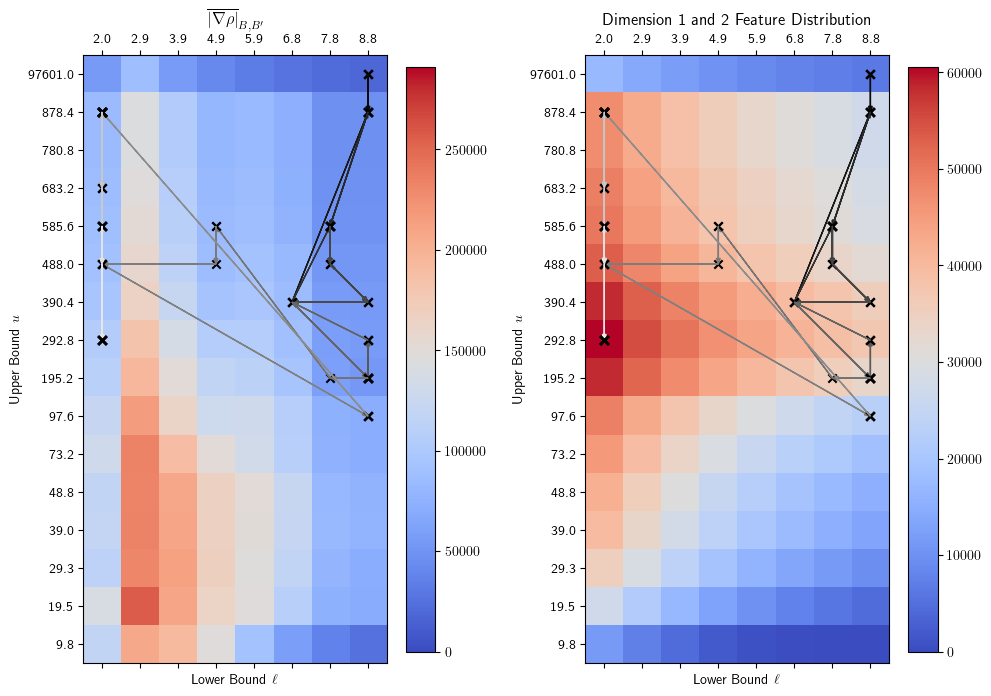

In [150]:
df_du = np.zeros((len(upper_list),len(lower_list)))
df_dl = np.zeros((len(upper_list),len(lower_list)))
df_dx_matrix = np.zeros((len(upper_list),len(lower_list)))
feature_D1_matrix = np.zeros((len(upper_list),len(lower_list)))
feature_D2_matrix = np.zeros((len(upper_list),len(lower_list)))

n = 0
for i in range(len(upper_list)):
    for j in range(1,len(lower_list)):
        grad_entry = df_dx_[(i,j)]

        df_dl[i,j] = grad_entry[0]
        df_du[i,j] = grad_entry[1]
        
        feature_D1_matrix[i,j] = fs_d1[(i,j)]
        feature_D2_matrix[i,j] = fs_d2[(i,j)]

        df_dx_matrix[i,j] = np.linalg.norm(df_dx_[(i,j)])

        n += 1

    

fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,12))

dmin = min(df_dl.min(), df_du.min())
dmax = (df_du + df_dl).max()
dnorm = colors.Normalize(dmin,dmax)
fmin = min(feature_D1_matrix.min(),feature_D2_matrix.min())
fmax = (feature_D2_matrix + feature_D1_matrix).max()
fnorm = colors.Normalize(fmin,fmax)

d1=ax[0].matshow(df_dx_matrix[::-1,1:], norm = dnorm, cmap = "coolwarm")
f1=ax[1].matshow(feature_D1_matrix[::-1,1:] + feature_D2_matrix[::-1,1:], norm=fnorm, cmap = "coolwarm")

fig.colorbar(d1, ax = ax[0],shrink=0.5)
fig.colorbar(f1, ax = ax[1],shrink=0.5)

greyscale = [0,0,0]
prior_index = (1, 7)
for index in optimal_indices:
    ax[0].scatter(index[1]-1,15-index[0],color='black', marker='x')
    ax[1].scatter(index[1]-1,15-index[0],color='black', marker='x')

    if prior_index != (1, 7):
        ax[0].arrow(prior_index[1]-1, 15-prior_index[0], (index[1] - prior_index[1]), -(index[0] - prior_index[0]), head_width = 0.1, length_includes_head=True, color=greyscale, width=0.0001)
        ax[1].arrow(prior_index[1]-1, 15-prior_index[0], (index[1] - prior_index[1]), -(index[0] - prior_index[0]), head_width = 0.1, length_includes_head=True, color=greyscale, width=0.0001)
    prior_index = index
    greyscale[0], greyscale[1], greyscale[2] = greyscale[0] + 0.01, greyscale[1] + 0.01, greyscale[2] + 0.01

for i in range(2):
        ax[i].set_xticklabels(np.round(lower_list,1))
        ax[i].set_yticks(np.arange(0,16))
        ax[i].set_yticklabels(np.round(upper_list[::-1],1))
        ax[i].set_xlabel(r'Lower Bound $\ell$')
        ax[i].set_ylabel(r'Upper Bound $u$')

ax[0].set_title(r"$\overline{|\nabla \rho|}_{B,B'}$")
ax[1].set_title(r'Dimension 1 and 2 Feature Distribution')

fig.tight_layout(w_pad=2, h_pad=-20)